 A simple **neural message passing scheme**, where node features $\mathbf{x}_v^{(\ell)}$ of all nodes $v \in \mathcal{V}$ in a graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ are iteratively updated by aggregating localized information from their neighbors $\mathcal{N}(v)$:

$$
\mathbf{x}_v^{(\ell + 1)} = f^{(\ell + 1)}_{\theta} \left( \mathbf{x}_v^{(\ell)}, \left\{ \mathbf{x}_w^{(\ell)} : w \in \mathcal{N}(v) \right\} \right)
$$

In [72]:
import os
import torch




import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color,title1):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())


    plt.figure(figsize=(10,10))
    

    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    # plt.colorbar(scatter)
    plt.title(title1)
    plt.show()

2.2.2+cu118


In [50]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes={data.val_mask.sum()}')
print(f'Number of test nodes={data.test_mask.sum()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Number of training nodes: 140
Number of validation nodes=500
Number of test nodes=1000


### Supervised Learning
Supervised learning relies on a dataset composed of input-output pairs where both the inputs and their corresponding outputs (labels) are provided.

### Semi-Supervised Learning
Semi-supervised learning uses a combination of a small amount of labeled data and a large amount of unlabeled data. This approach is especially useful when labels are difficult or expensive to obtain. Only the Labed data are used in Loss function unlike in supervised learning all the training data are used when calculating loss function

## Training a Multi-layer Perception Network (MLP)


In [51]:
import torch
from torch.nn import Linear
import torch.nn.functional as F



class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        # self.lin2 = Linear(hidden_channels, hidden_channels)
        # self.lin3 = Linear(hidden_channels, hidden_channels)

        self.lin4 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        
        # x = self.lin2(x)
        # x = x.relu()
        # x = F.dropout(x, p=0.5, training=self.training)

        # x = self.lin3(x)
        # x = x.relu()
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin4(x)
        return x 

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin4): Linear(in_features=16, out_features=7, bias=True)
)


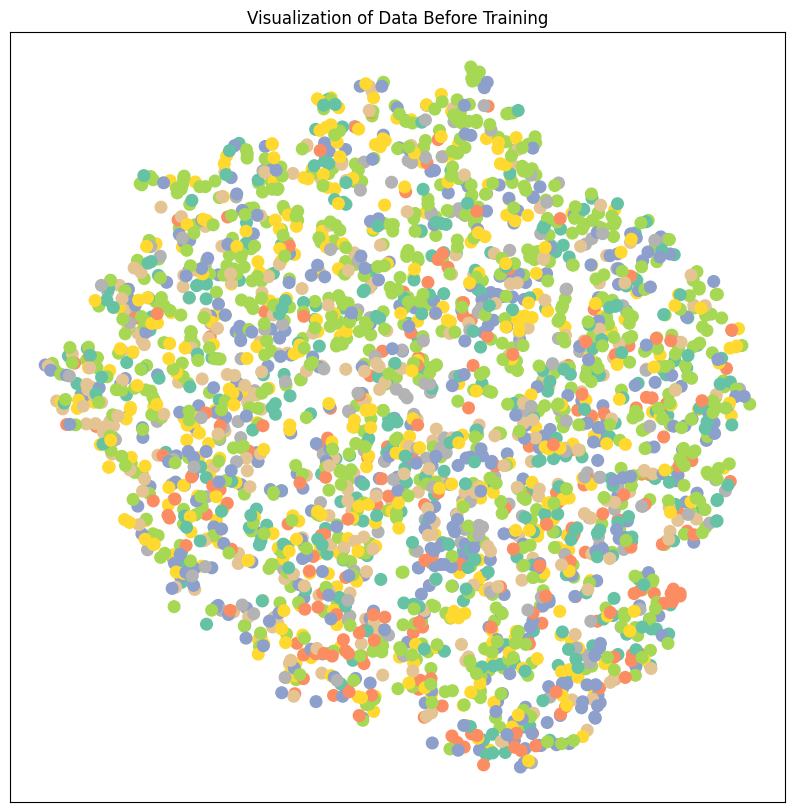

In [53]:
model = MLP(hidden_channels=16)
model.eval()
output = model(data.x)
visualize(output,color=data.y,title1="Visualization of Data Before Training")#visulaizing before training



In [54]:
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
def train():
    model.train()
    optimizer.zero_grad()

    train_features = data.x[data.train_mask]
    train_labels = data.y[data.train_mask]

    out = model(train_features)
    loss = criterion(out, train_labels)
    loss.backward()
    optimizer.step()
    return loss

def validate():
    model.eval()
    with torch.no_grad():
        val_features = data.x[data.val_mask]
        val_labels = data.y[data.val_mask]

        out = model(val_features)
        loss = criterion(out, val_labels)
        pred = out.argmax(dim=1)
        correct = pred == val_labels
        acc = int(correct.sum()) / int(data.val_mask.sum())
        return loss, acc

def test():
    model.eval()
    with torch.no_grad():
        test_features = data.x[data.test_mask]
        test_labels = data.y[data.test_mask]

        out = model(test_features)
        pred = out.argmax(dim=1)
        correct = pred == test_labels
        acc = int(correct.sum()) / int(data.test_mask.sum())
        return acc

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(1, 201):
    train_loss = train()
    val_loss, val_acc = validate()
    
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    val_accuracies.append(val_acc)

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}')

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 001, Train Loss: 1.9615, Validation Loss: 2.0273, Validation Acc: 0.1140
Epoch: 002, Train Loss: 1.9557, Validation Loss: 2.0184, Validation Acc: 0.1340
Epoch: 003, Train Loss: 1.9505, Validation Loss: 2.0091, Validation Acc: 0.0920
Epoch: 004, Train Loss: 1.9423, Validation Loss: 1.9993, Validation Acc: 0.0900
Epoch: 005, Train Loss: 1.9327, Validation Loss: 1.9891, Validation Acc: 0.0880
Epoch: 006, Train Loss: 1.9279, Validation Loss: 1.9790, Validation Acc: 0.0880
Epoch: 007, Train Loss: 1.9144, Validation Loss: 1.9693, Validation Acc: 0.0920
Epoch: 008, Train Loss: 1.9087, Validation Loss: 1.9599, Validation Acc: 0.1060
Epoch: 009, Train Loss: 1.9023, Validation Loss: 1.9508, Validation Acc: 0.1340
Epoch: 010, Train Loss: 1.8893, Validation Loss: 1.9419, Validation Acc: 0.1880
Epoch: 011, Train Loss: 1.8776, Validation Loss: 1.9332, Validation Acc: 0.2180
Epoch: 012, Train Loss: 1.8594, Validation Loss: 1.9246, Validation Acc: 0.2360
Epoch: 013, Train Loss: 1.8457, Validati

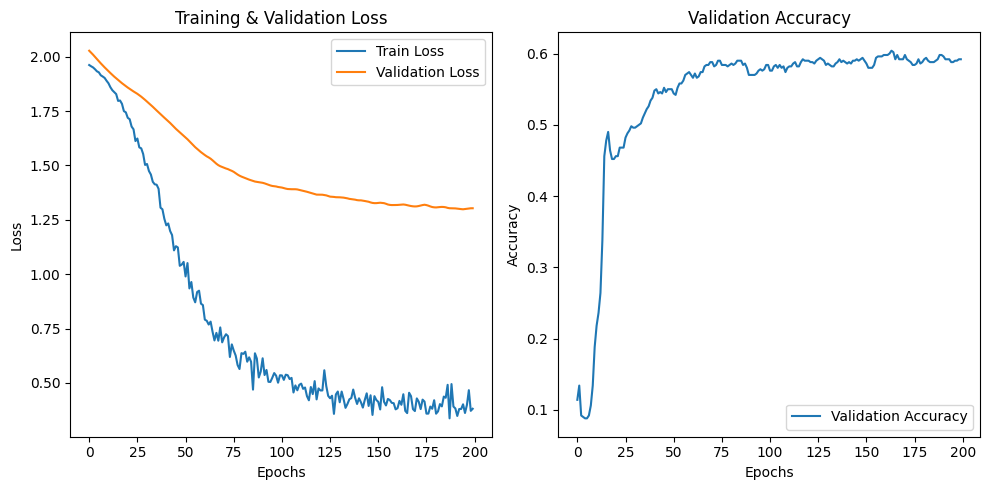

In [55]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


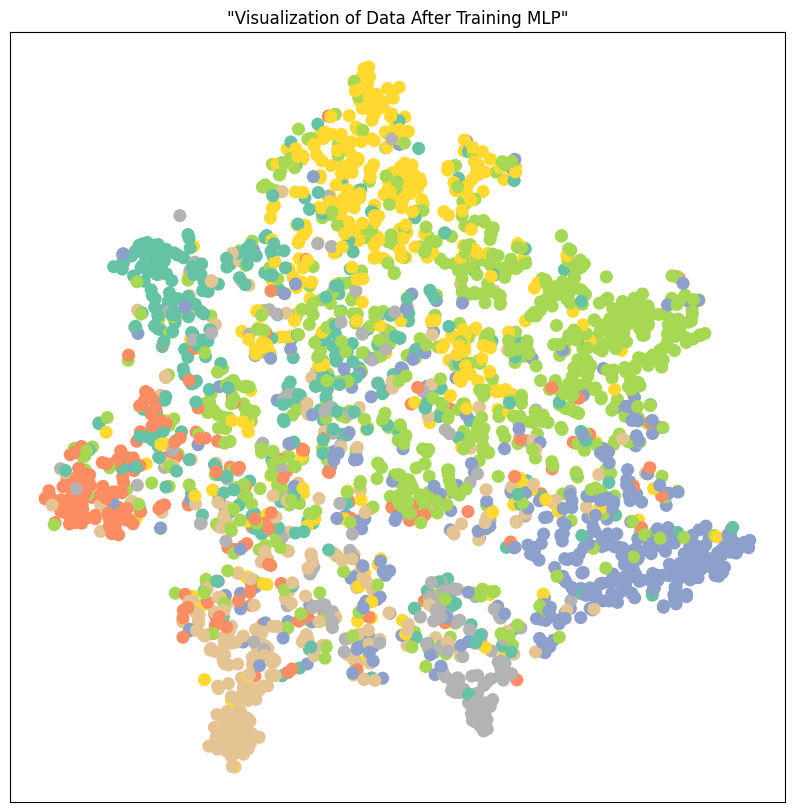

In [57]:
# test_acc = test()
# print(f'Test Accuracy: {test_acc:.4f}')

#to visvalize of MLP training 
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    output = model(data.x)  # Get the model outputs
visualize(output,color=data.y,title1='"Visualization of Data After Training MLP"')

Model has been trained for various hidden neuron and with different number of layers, however hidden with 16 always yeilds the best result (59%) in test data.
The main reason for that is that this model suffers from heavy overfitting due to only having access to a **small amount of training nodes**, and therefore generalizes poorly to unseen node representations.

## Training a Graph Neural Network (GNN)

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information

In [69]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(dataset.num_features, dataset.num_classes, hidden_channels=17)


print(data.x.shape)
print(model)

torch.Size([2708, 1433])
GCN(
  (conv1): GCNConv(1433, 17)
  (conv2): GCNConv(17, 7)
)


Visualizing untrrained model

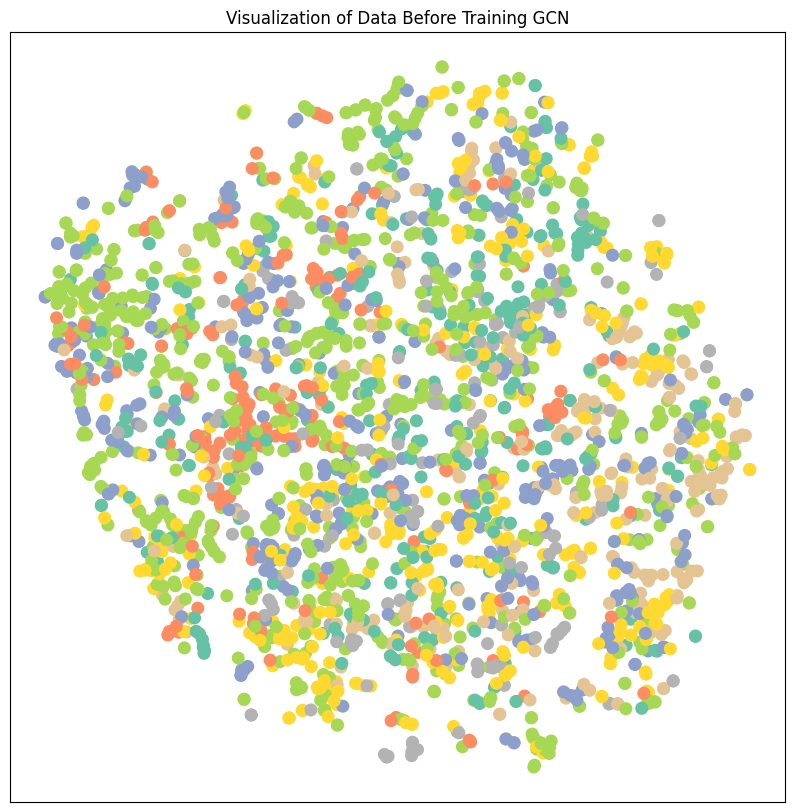

In [61]:
model.eval()

out = model(data.x, data.edge_index)
# visualize(output,color=data.y)
visualize(out,color=data.y,title1="Visualization of Data Before Training GCN")

In below code, all the data points are used for training but only data points that have targets are used to claculate loss and thereby calculating gradient and updating the weights

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9460, train:0.40714285714285714 Val: 0.3080, Test: 0.2980
Epoch: 002, Loss: 1.9420, train:0.6357142857142857 Val: 0.4640, Test: 0.4220
Epoch: 003, Loss: 1.9368, train:0.6642857142857143 Val: 0.4140, Test: 0.4150
Epoch: 004, Loss: 1.9286, train:0.5571428571428572 Val: 0.2920, Test: 0.3280
Epoch: 005, Loss: 1.9234, train:0.5642857142857143 Val: 0.2840, Test: 0.3240
Epoch: 006, Loss: 1.9131, train:0.6357142857142857 Val: 0.3320, Test: 0.3510
Epoch: 007, Loss: 1.9050, train:0.7071428571428572 Val: 0.4220, Test: 0.4310
Epoch: 008, Loss: 1.8951, train:0.8142857142857143 Val: 0.5360, Test: 0.5210
Epoch: 009, Loss: 1.8835, train:0.85 Val: 0.6080, Test: 0.5810
Epoch: 010, Loss: 1.8712, train:0.8714285714285714 Val: 0.6300, Test: 0.6330
Epoch: 011, Loss: 1.8565, train:0.8857142857142857 Val: 0.6560, Test: 0.6640
Epoch: 012, Loss: 1.8474, train:0.9 Val: 0.6760, Test: 0.6850
Epoch: 013, Loss: 1.8334, train:0.9142857142857143 Val: 0.6920, Test: 0.7160
Epoch: 014, Loss: 1.8236, t

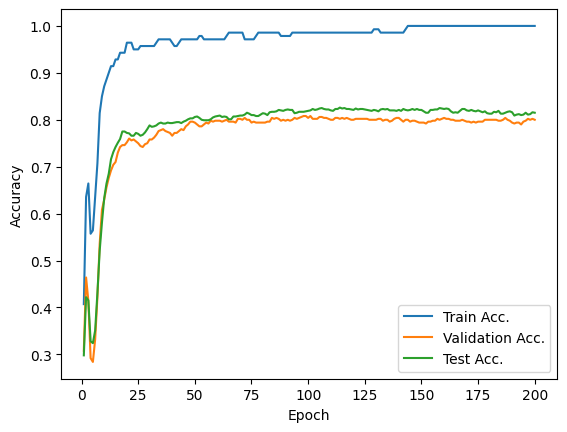

In [70]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(dataset.num_features, dataset.num_classes, hidden_channels=17)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = pred[mask] == data.y[mask]
        acc = int(correct.sum()) / int(mask.sum())
      return acc


# for epoch in range(1, 101):
#     loss = train()
#     print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

train_accs = []
val_accs = []
test_accs = []
epochs = 201
for epoch in range(1, epochs):
    loss = train()
    train_acc = test(data.train_mask)
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    
    # Append accuracy values for plotting
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, train:{train_acc} Val: {val_acc:.4f}, Test: {test_acc:.4f}')

# Plot validation and test accuracies
plt.plot(range(1, epochs), train_accs, label='Train Acc.')
plt.plot(range(1, epochs), val_accs, label='Validation Acc.')
plt.plot(range(1, epochs), test_accs, label='Test Acc.')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [71]:
test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8150


Visvalizing after training

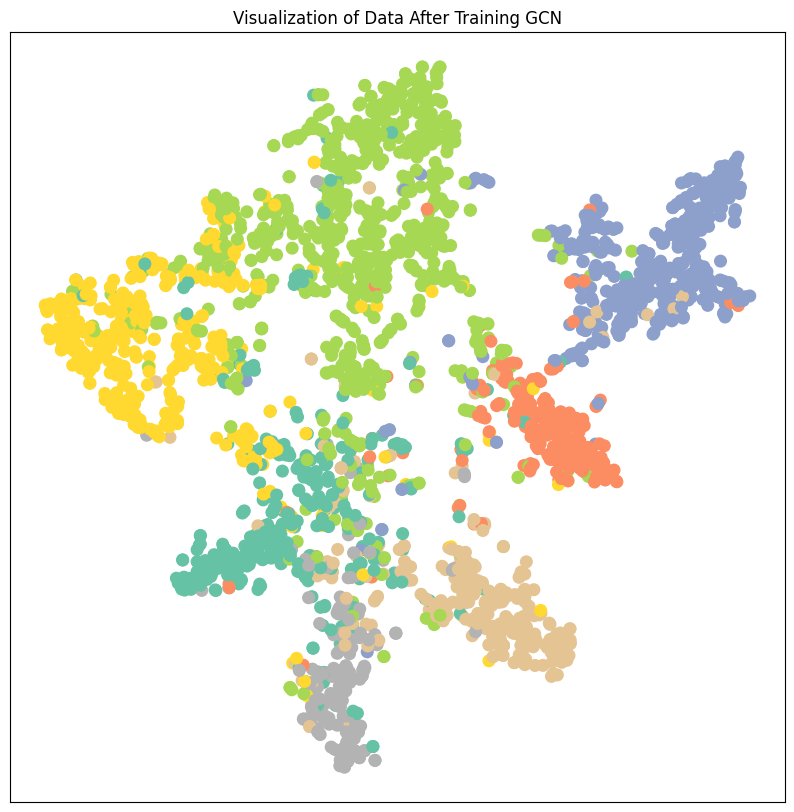

In [65]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out,color=data.y,title1="Visualization of Data After Training GCN")

**NOT required for correction**

**Implementing GAT**

Other than GAN, GAT network has been implement. Instead on assiging equal importance to all the neighbours, GAT assigns importance dynamically based on the feature.


\begin{equation}
\mathbf{h}_v^{(\ell + 1)} = \sigma \left( \sum_{w \in \mathcal{N}(v) \cup \{ v \}} \frac{\exp(e_{vw})}{\sum_{u \in \mathcal{N}(v) \cup \{ v \}} \exp(e_{vu})} \cdot \mathbf{W}^{(\ell)} \mathbf{h}_w^{(\ell)} \right)
\end{equation}
where $e_{vw}$ represents the attention score between nodes $v$ and $w$ which is calculated using attention mechanisim


GAT(
  (conv1): GATConv(1433, 20, heads=1)
  (conv2): GATConv(20, 7, heads=1)
)
Epoch: 001, Loss: 1.9468, Val: 0.1420, Test: 0.1470
Epoch: 002, Loss: 1.9385, Val: 0.2200, Test: 0.2330
Epoch: 003, Loss: 1.9368, Val: 0.4580, Test: 0.4700
Epoch: 004, Loss: 1.9290, Val: 0.6200, Test: 0.6400
Epoch: 005, Loss: 1.9222, Val: 0.6380, Test: 0.6690
Epoch: 006, Loss: 1.9205, Val: 0.6460, Test: 0.6810
Epoch: 007, Loss: 1.9127, Val: 0.6720, Test: 0.6830
Epoch: 008, Loss: 1.9081, Val: 0.6900, Test: 0.6870
Epoch: 009, Loss: 1.9008, Val: 0.7060, Test: 0.7060
Epoch: 010, Loss: 1.8932, Val: 0.7080, Test: 0.7090
Epoch: 011, Loss: 1.8893, Val: 0.7000, Test: 0.7170
Epoch: 012, Loss: 1.8804, Val: 0.7240, Test: 0.7290
Epoch: 013, Loss: 1.8784, Val: 0.7420, Test: 0.7620
Epoch: 014, Loss: 1.8686, Val: 0.7680, Test: 0.7810
Epoch: 015, Loss: 1.8596, Val: 0.7840, Test: 0.7920
Epoch: 016, Loss: 1.8605, Val: 0.7860, Test: 0.7990
Epoch: 017, Loss: 1.8433, Val: 0.7760, Test: 0.7880
Epoch: 018, Loss: 1.8389, Val: 0.772

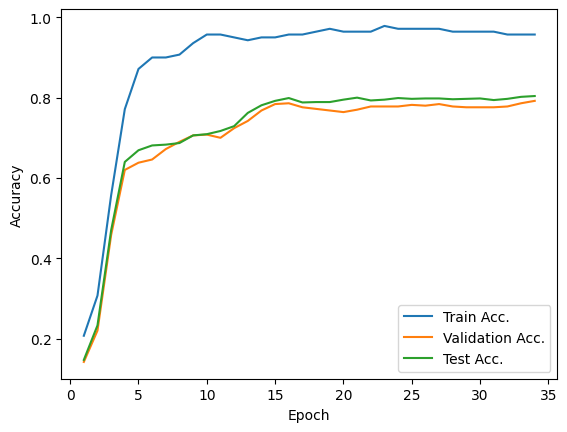

In [73]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(data.num_features,20)  # TODO
        self.conv2 = GATConv(20,7)  # TODO
        # self.conv3 = GATConv(2,7)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        # x = F.elu(x)
        # x = F.dropout(x, p=0.6, training=self.training)
        # x = self.conv3(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc


# for epoch in range(1, 20):
#     loss = train()
#     train_acc = test(data.train_mask)
#     val_acc = test(data.val_mask)
#     test_acc = test(data.test_mask)
#     print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')
#     plt.plot(epoch,val_acc)
#     plt.plot(epoch,test_acc)
# plt.show()
train_accs = []
val_accs = []
test_accs = []
epoch=35
for epoch in range(1, epoch):
    loss = train()
    train_acc = test(data.train_mask)
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    
    # Append accuracy values for plotting
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

# Plot validation and test accuracies
plt.plot(range(1, epoch+1), train_accs, label='Train Acc.')
plt.plot(range(1, epoch+1), val_accs, label='Validation Acc.')
plt.plot(range(1, epoch+1), test_accs, label='Test Acc.')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Test Accuracy: 0.8040


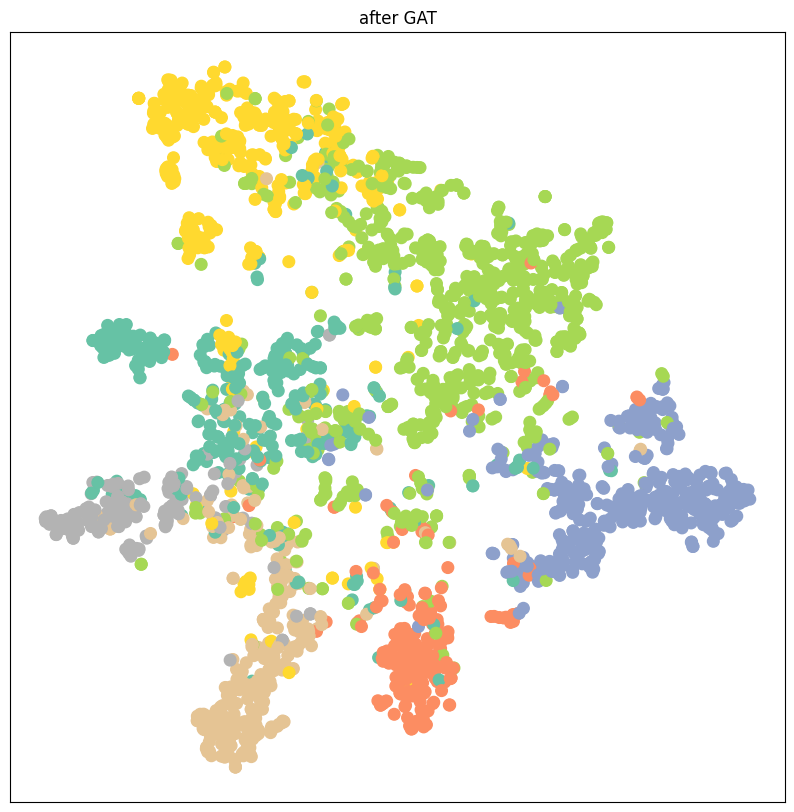

In [74]:
test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y,title1= "after GAT")